In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [10]:
df = pd.read_csv('data/calls_weather_tfk.csv')

In [11]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [12]:
df.set_index(df['DATE'], inplace = True)

<AxesSubplot:xlabel='DATE'>

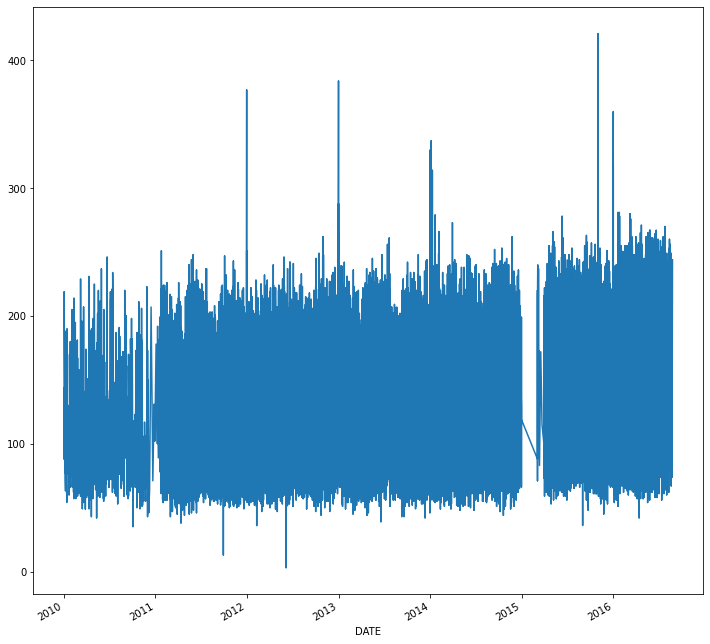

In [24]:
plt.figure(figsize=(12,12))
df['num_calls'].plot()

In [19]:
X = df.drop(columns = ['num_calls', 'BROOKLYN', 'BRONX' ,'MANHATTAN', 
                       'UNKNOWN','Unnamed: 0', 'RICHMOND / STATEN ISLAND','DATE'
                       ])
y = df['num_calls']

X = pd.get_dummies(X, columns = ['STATION'])
X = pd.get_dummies(X, columns = ['NAME'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [20]:
X.shape

(25241, 14)

In [25]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 3, batch_size = 64)

test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size = 64)

In [32]:
d = train_sequences[0][0][0].shape

#### **Need to rework the structure of the Neural Network to be able to run time series**

In [34]:
stop = EarlyStopping(monitor = 'mae', patience = 10, min_delta = .01)

# set up structure
model = Sequential()
model.add(GRU(8, input_shape=(14,), return_sequences=True))
model.add(GRU(8, return_sequences=False))

model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=.0005), loss='binary_crossentropy', metrics=['acc'])

# compile
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

results = model.fit(X_train_sc, y_train, 
          epochs = 100,
          batch_size = 256,
          validation_data = (X_test_sc, y_test),
          callbacks = stop,
                   verbose = 1)

Epoch 1/100
74/74 [==============================] - 1s 4ms/step - loss: 18321.8198 - mae: 124.8038 - val_loss: 3489.3630 - val_mae: 47.8336
Epoch 2/100
74/74 [==============================] - 0s 3ms/step - loss: 2125.7634 - mae: 35.6265 - val_loss: 1077.3512 - val_mae: 25.5734
Epoch 3/100
74/74 [==============================] - 0s 3ms/step - loss: 1023.1804 - mae: 24.7307 - val_loss: 875.9909 - val_mae: 22.9436
Epoch 4/100
74/74 [==============================] - 0s 3ms/step - loss: 858.1611 - mae: 22.4740 - val_loss: 772.1789 - val_mae: 21.5449
Epoch 5/100
74/74 [==============================] - 0s 3ms/step - loss: 742.9211 - mae: 21.0448 - val_loss: 705.3809 - val_mae: 20.6198
Epoch 6/100
74/74 [==============================] - 0s 3ms/step - loss: 680.4353 - mae: 20.2421 - val_loss: 654.1406 - val_mae: 19.9018
Epoch 7/100
74/74 [==============================] - 0s 3ms/step - loss: 646.9501 - mae: 19.7208 - val_loss: 613.7202 - val_mae: 19.3302
Epoch 8/100
74/74 [===============

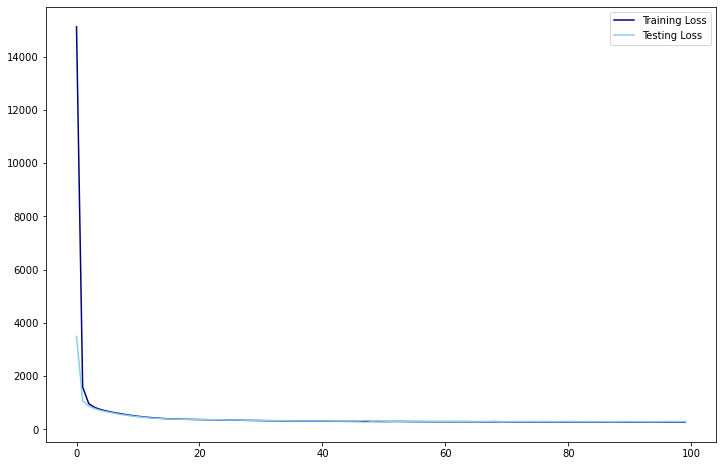

In [35]:
train_mae = results.history['loss']
test_mae =  results.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_mae, label='Training Loss', color='navy')
plt.plot(test_mae, label='Testing Loss', color='skyblue')
plt.legend();